## Model evaluation

### Binary classification: negative or postive

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
#using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

In [ ]:
include("../common/reporting.jl")
include("../common/vocab.jl")
include("../common/training.jl")

update_history! (generic function with 1 method)

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [ ]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20230701_1811_n1_none"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => identity
  :indexer   => IndexTokenizer{String}(length(vocabulary)=6654, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = identity
indexer = IndexTokenizer{String}(length(vocabulary)=6654, unksym=[UNK])


TransformerClassifier(
  Embed((32, 6654)),                    # 212_928 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 1),                       # 51 parameters
)        # Total: 21 trainable arrays, 225_716 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1008.391 KiB.

In [ ]:
max_sentence_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3

@time tokens = map(d->preprocess(d, tokenizer, max_length=max_sentence_length), documents[idxs])
@time indices = indexer(tokens) 

X_train = indices
Y_train = reshape(y_train[idxs], 1, :)
train_data, val_data = split_validation(MersenneTwister(2718), X_train, Y_train)

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  3.587261 seconds (22.23 M allocations: 1.380 GiB, 16.92% gc time, 1.64% compilation time)
 16.144163 seconds (4 allocations: 62.256 MiB, 0.12% gc time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [ ]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_sentence_length), documents_test) 
@time indices_test = indexer(tokens_test)

documents_test_sub = documents_test[idxs]
X_test = indices_test[:, idxs]

println("test documents: ", size(documents_test_sub))
println("test samples: ", size(X_test), " ", size(y_test))

  0.197282 seconds (733.48 k allocations: 46.643 MiB, 12.62% gc time, 34.68% compilation time)
  0.367956 seconds (5 allocations: 1.946 MiB)
test documents: (4000,)
test samples: (50, 4000) (1, 4000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [ ]:
loss(ŷ::AbstractMatrix, y::AbstractMatrix) = Flux.logitbinarycrossentropy(ŷ, y)
accuracy(ŷ::AbstractMatrix, y::AbstractMatrix) = mean((Flux.sigmoid.(ŷ) .> 0.5) .== y)

accuracy (generic function with 1 method)

In [ ]:
@time batched_metrics(model, train_data_loader, loss, accuracy)

 41.749319 seconds (10.71 M allocations: 44.575 GiB, 7.99% gc time, 15.05% compilation time)


(loss = 0.22551213f0, accuracy = 0.908875f0)

In [ ]:
@time batched_metrics(model, val_data_loader, loss, accuracy)

  7.715591 seconds (115.17 k allocations: 4.885 GiB, 8.96% gc time)


(loss = 0.21668127f0, accuracy = 0.9108125f0)

In [ ]:
history = open(joinpath(directory, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.336966, 0.291907, 0.274545, 0.26149, 0.252985, 0.242272…
  "train_acc"  => Any[0.851708, 0.876347, 0.885715, 0.892181, 0.896167, 0.90012…
  "val_acc"    => Any[0.841812, 0.864, 0.869687, 0.872938, 0.87725, 0.875625, 0…
  "val_loss"   => Any[0.34648, 0.311861, 0.298408, 0.298076, 0.300272, 0.297974…

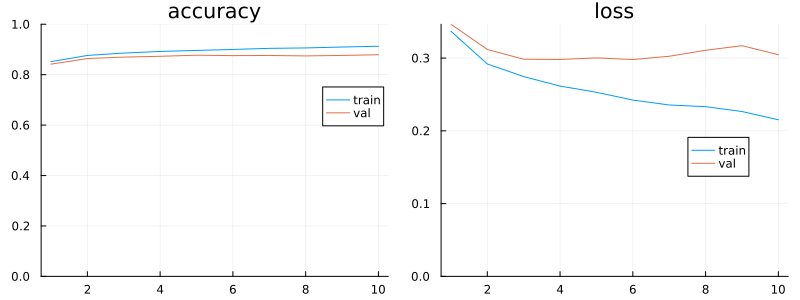

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.86875

In [ ]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [ ]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1770   230
  295  1705

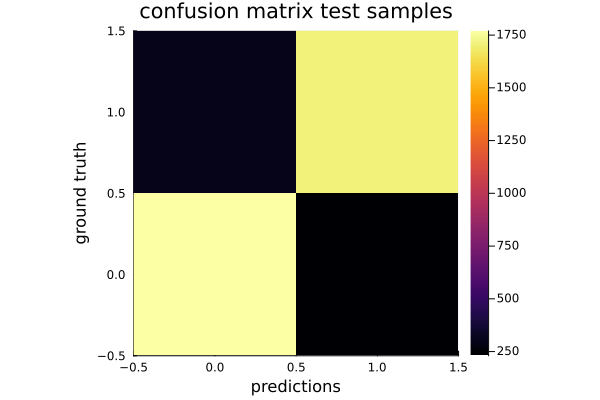

In [ ]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [ ]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.86    0.89      0.87     2000
           1       0.88    0.85      0.87     2000

weighted avg       0.87    0.87      0.87     4000

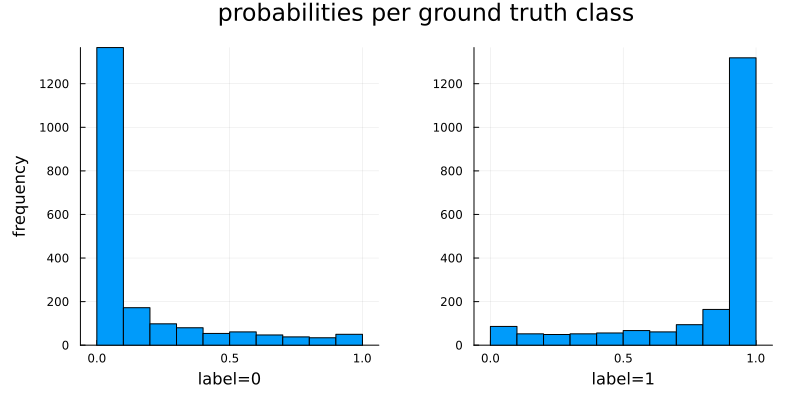

In [ ]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [ ]:
pos_max = argmax(probs)[2]
pos_min = argmin(probs)[2]

println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
2207  1  1  1.0000  I am very pleased with this product. Exactly what we wanted for our dog. Very happy with our purchase
 500  0  0  0.0000  Cheaply made. It broke during first use and it is not easily returnable.


In [ ]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, y_test[idx], y_pred[idx], probs[idx], documents_test_sub[idx]
            )
        end
    end
    println("")
end

correct: 1770 / 2000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
 180  0  0  0.0418  My printer will not recognize the cartridges. I need to send them back.
----------------------------------------------------------------------------------------------------
1040  0  0  0.1395  Flag itself was on point. Suction cup to secure the flag sucked.
----------------------------------------------------------------------------------------------------
 812  0  0  0.0011  Cable tester defective right out of the box. Stuck flashing on port one as others have stated. Tested on known good cables, still stuck flashing on port one. Buyer beware, you get what you pay for.
----------------------------------------------------------------------------------------------------
1145  0  1  0.9577  None of my dogs will eat them. I am a groomer and none of my clients dogs like this flavor either. Everyone enjoys the plain liver version 

## Test data including star=3

In [ ]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

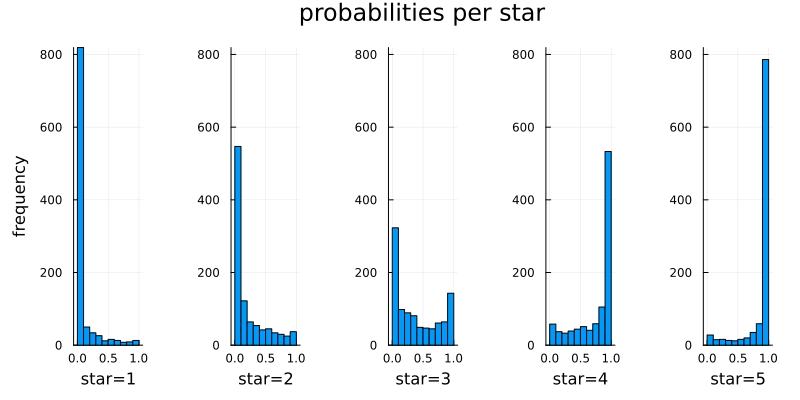

In [ ]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [ ]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    println("-"^100)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

star = 3
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
2056  3  0  0.0443  I like the print, but the product image is deceiving. I though the background was an off-white/tan color, but in reality it is a bright white.
----------------------------------------------------------------------------------------------------
2942  3  1  0.6735  Look good but receive a day late
----------------------------------------------------------------------------------------------------
2418  3  0  0.2739  Was quite an enjoyable family movie up until the very end when the two of us were very disappointed with the totally unnecessary last scene ...too bad.......


## Single samples

In [ ]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
println("")

tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
println("")

x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.

this|makes|almost|the|whole|series|roman|nights|will|be|the|last|one|loved|them|all|alaskan|nights|was|awesome|met|my|expectations|hot|seal|hero|beautiful|feisty|woman|filled|with|intrigue|steamy|romance|nail|biting|ending|have|read|two|other|books|of|yours|am|looking|forward|to|more

8|240|299|2|460|607|1|2433|44|28|2|164|27|230|32|37|1|2433|14|461|3214|11|1562|407|821|3514|339|1|1767|1371|17|5779|5817|1881|1508|6438|1382|18|179|105|79|547|9|5233|102|165|770|5|57|1


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
 -0.179219    0.03037    -1.1295     …  -0.365355    -0.104359    0.0207665
 -0.81813    -0.564783   -0.0102154     -0.91518     -0.373973   -0.0114071
 -0.764596   -0.107669   -1.33626       -0.348852    -0.673321    0.0387014
 -0.460479   -0.0759877   1.04088       -0.715451    -0.0672792   0.162378
 -0.916315    0.311829    0.540096       1.54267      1.28488    -0.203565
 -0.854204    0.311591   -1.59773    …  -0.417489    -0.768665    0.203725
 -0.803133   -0.714727   -0.418436      -0.0764715   -1.34857    -0.877865
 -0.440586    0.284455    1.18252       -0.458935    -0.399891   -1.04481
  0.753724   -0.438035   -1.11187       -1.60813      0.410237    1.85737
 -0.378113    0.261494   -0.492448       0.677472    -0.0223616   1.31106
  0.192095   -0.387472   -0.844999   …   0.0602017    0.260336   -0.809815
 -1.07284     1.28401    -0.790979       0.194377    -1.26994     0.790972
 -0.739732    0.375312    1.8006         0.235898    -1.64578     0.791642
  

In [ ]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.998928